# Asset Portfolio Management using Deep Reinforcement Learning
---

## 6 Backtesting and Evaluation of the Portfolios

### 6.1 Import Relevant Packages

In [61]:
import numpy as np 
import pandas as pd 
import pyfolio as pf
from pyfolio import timeseries
import matplotlib.pylab as plt
from backtest import BackTestStats, BaselineStats, BackTestPlot, backtest_strat, baseline_strat

In [62]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### 6.2 Load the Train and Test Data for Portfolios

In [98]:
%store -r max_sharpe_portfolio
%store -r uniform_weights_port

%store -r prices_train_df
%store -r prices_test_df


%store -r a2c_train_daily_return
%store -r ppo_train_daily_return
%store -r ddpg_train_daily_return

%store -r a2c_test_returns 
%store -r ppo_test_returns 
%store -r ddpg_test_returns 

In [99]:
returns_train = prices_train_df.pct_change() # get the assets daily returns
returns_test = prices_test_df.pct_change()

# get the culmulative returns for each portfolio
uw_weights = uniform_weights_port.values.flatten()
uw_returns = returns_train.dot(uw_weights)
uw_cum_returns = (1 + uw_returns).cumprod()
uw_cum_returns.name = "portfolio 1: uniform weights"

max_sharpe_weights = max_sharpe_portfolio.values.flatten()
max_sharpe_returns = returns_train.dot(max_sharpe_weights)
max_sharpe_cum_returns = (1 + max_sharpe_returns).cumprod()
max_sharpe_cum_returns.name = "portfolio 2: max sharpe"

a2c_train_cum_returns = (1 + a2c_train_daily_return.reset_index(drop=True).set_index(['date'])).cumprod()
a2c_train_cum_returns = a2c_train_cum_returns['daily_return']
a2c_train_cum_returns.name = 'Portfolio 3: a2c Model'

ppo_train_cum_returns = (1 + ppo_train_daily_return.reset_index(drop=True).set_index(['date'])).cumprod()
ppo_train_cum_returns = ppo_train_cum_returns['daily_return']
ppo_train_cum_returns.name = 'Portfolio 4: ppo Model'

ddpg_train_cum_returns = (1 + ddpg_train_daily_return.reset_index(drop=True).set_index(['date'])).cumprod()
ddpg_train_cum_returns = ddpg_train_cum_returns['daily_return']
ddpg_train_cum_returns.name = 'Portfolio 5: ddpg Model'

date_list = list(ddpg_train_cum_returns.index)

max_sharpe_cum_returns = max_sharpe_cum_returns[(max_sharpe_cum_returns.index).isin (date_list)]
uw_cum_returns = uw_cum_returns[(uw_cum_returns.index).isin (date_list)]


C:\Users\VisionHigh\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


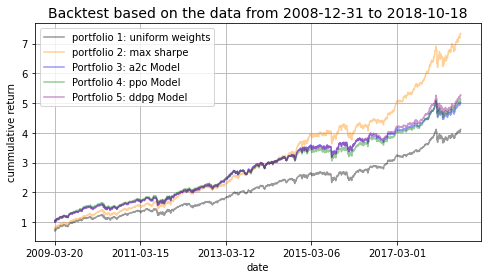

In [100]:
# Plot the culmulative returns of the portfolios
fig, ax = plt.subplots(figsize=(8,4))
uw_cum_returns.plot(ax=ax, color="black", alpha=0.4);
max_sharpe_cum_returns.plot(ax=ax, color="darkorange", alpha=0.4);

a2c_train_cum_returns.plot(ax=ax, color='blue', alpha=0.4)
ppo_train_cum_returns.plot(ax=ax, color='green', alpha=0.4)
ddpg_train_cum_returns.plot(ax=ax, color='purple', alpha=0.4)

plt.legend(loc="best");
plt.grid(True);
ax.set_ylabel("cummulative return");
ax.set_title("Backtest based on the data from 2008-12-31 to 2018-10-18", fontsize=14);
fig.savefig('results/back_test_on_train_data.png');

### 6.4 Evaluating the Portfolios on Test Data

In [101]:
# get the culmulative returns for each portfolio
uw_weights = uniform_weights_port.values.flatten()
uw_test_returns = returns_test.dot(uw_weights)
uw_test_cum_returns = (1 + uw_test_returns).cumprod()
uw_test_cum_returns.name = "portfolio 1: uniform weights"

max_sharpe_weights = max_sharpe_portfolio.values.flatten()
max_sharpe_test_returns = returns_test.dot(max_sharpe_weights)
max_sharpe_test_cum_returns = (1 + max_sharpe_test_returns).cumprod()
max_sharpe_test_cum_returns.name = "portfolio 2: max sharpe"

a2c_test_cum_returns = (1 + a2c_test_returns['daily_return']).cumprod()
a2c_test_cum_returns.name = 'Portfolio 3: a2c Model'

ppo_test_cum_returns = (1 + ppo_test_returns['daily_return']).cumprod()
ppo_test_cum_returns.name = 'Portfolio 4: ppo Model'

ddpg_test_cum_returns = (1 + ddpg_test_returns['daily_return']).cumprod()
ddpg_test_cum_returns.name = 'Portfolio 5: ddpg Model'

C:\Users\VisionHigh\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


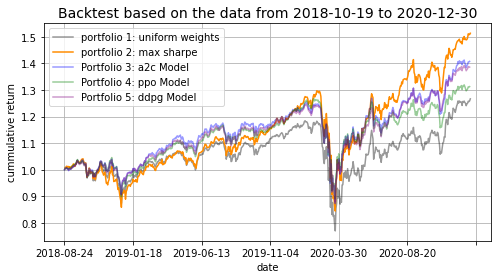

In [102]:
# Plot the culmulative returns of the portfolios
fig, ax = plt.subplots(figsize=(8,4))
uw_test_cum_returns.plot(ax=ax, color="black", alpha=.4);
max_sharpe_test_cum_returns.plot(ax=ax, color="darkorange");
a2c_test_cum_returns.plot(ax=ax, color='blue', alpha=.4)
ppo_test_cum_returns.plot(ax=ax, color='green', alpha=.4)
ddpg_test_cum_returns.plot(ax=ax, color='purple', alpha=.4)
plt.legend(loc="best");
plt.grid(True);
ax.set_ylabel("cummulative return");
ax.set_title("Backtest based on the data from 2018-10-19 to 2020-12-30", fontsize=14);
fig.savefig('results/back_test_on_test_data.png');

### 6.5 Get the Portfolio Statistics

In [103]:
# Define a Function for Getting the Portfolio Statistics

def portfolio_stats(portfolio_returns):
    # Pass the returns into a dataframe
    port_rets_df = pd.DataFrame(portfolio_returns)
    port_rets_df = port_rets_df.reset_index()
    port_rets_df.columns = ['date','daily_return']
    
    #Use the FinRL Library to get the Portfolio Returns
    #This makes use of the Pyfolio Library
    
    DRL_strat = backtest_strat(port_rets_df)
    perf_func = timeseries.perf_stats 
    perf_stats_all = perf_func( returns=DRL_strat, 
                                  factor_returns=DRL_strat, 
                                    positions=None, transactions=None, turnover_denom="AGB")
    perf_stats_all = pd.DataFrame( perf_stats_all)
    perf_stats_all.columns = ['Statistic']
    return perf_stats_all

In [104]:
uw_test_returns.shape

(593,)

In [105]:
# Get the Portfolio Statistics for all the portfolios
portfolios_returns_dict = {'uniform_weights':uw_test_returns, 'maximum_sharpe':max_sharpe_test_returns,
                          'a2c Model': a2c_test_returns['daily_return'],
                          'ppo Model': ppo_test_returns['daily_return'],
                          'ddpg Model': ddpg_test_returns['daily_return']}

portfolios_stats = pd.DataFrame()
for i,j in portfolios_returns_dict.items():
    port_stats = portfolio_stats(j)
    portfolios_stats[i] = port_stats['Statistic']

In [106]:
portfolios_stats

,uniform_weights,maximum_sharpe,a2c Model,ppo Model,ddpg Model
Annual return,0.105787,0.192664,0.156780,0.122878,0.149199
Cumulative returns,0.266969,0.513771,0.407957,0.312931,0.386375
Annual volatility,0.260248,0.268582,0.237111,0.237551,0.229603
Sharpe ratio,0.517581,0.792533,0.733154,0.606988,0.721078
Calmar ratio,0.302289,0.552062,0.515068,0.413202,0.508426
Stability,0.291490,0.742925,0.665671,0.649122,0.674682
Max drawdown,-0.349952,-0.348990,-0.304388,-0.297381,-0.293452
Omega ratio,1.116673,1.187206,1.166903,1.138541,1.166663
Sortino ratio,0.727605,1.105307,1.043685,0.857330,1.014458
Skew,NaN,NaN,-0.233112,-0.223606,-0.447867


### 6.6 Benchmarking the Best Portfolio against the Benchmark Index

In [107]:
#a2c_test_returns = a2c_test_returns.set_index('date')
ppo_test_returns = ppo_test_returns.set_index('date')
ddpg_test_returns = ddpg_test_returns.set_index('date')

In [108]:
a2c_test_returns.head()

,date,daily_return
0,2018-08-24,0.000000
1,2018-08-27,0.004659
2,2018-08-28,0.000298
3,2018-08-29,0.002763
4,2018-08-30,-0.004444


In [109]:
# Getting the best performing portfolio

ps_cum = [a2c_test_cum_returns, ppo_test_cum_returns,ddpg_test_cum_returns]
ps = [a2c_test_returns['daily_return'], ppo_test_returns['daily_return'], ddpg_test_returns['daily_return']]

final_return = []
for p in ps_cum:
    final_return.append(p.iloc[-1])
    
id_ = np.argmax(final_return)
best_p = ps[id_]
best_p.name = (ps_cum[id_]).name 

print("Best portfolio: ",  best_p.name)
print("Final cumulative return: {:.2f} ".format(final_return[id_]))

Best portfolio:  Portfolio 3: a2c Model
Final cumulative return: 1.41 


In [110]:
# convert the best portfolio into a Dataframe

best_p = pd.DataFrame(best_p)
best_p = best_p.reset_index()
best_p.columns=['date','daily_return']
best_p['date'] = a2c_test_returns['date']

In [111]:
best_p.head()

,date,daily_return
0,2018-08-24,0.000000
1,2018-08-27,0.004659
2,2018-08-28,0.000298
3,2018-08-29,0.002763
4,2018-08-30,-0.004444


In [112]:
# Best portfolio stats
best_port_strat = backtest_strat(best_p)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=best_port_strat, 
                              factor_returns=best_port_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

In [113]:
prices_test_dates = list(prices_test_df.index)

print("==============Get Index Stats===========")
baesline_perf_stats=BaselineStats('^DJI',
                                  baseline_start = prices_test_dates[0],
                                  baseline_end = prices_test_dates[-1])

==============Get Index Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (593, 7)
Annual return          0.074890
Cumulative returns     0.185235
Annual volatility      0.265505
Sharpe ratio           0.406106
Calmar ratio           0.201934
Stability              0.151322
Max drawdown          -0.370862
Omega ratio            1.091303
Sortino ratio          0.557801
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.860941
Daily value at risk   -0.033023
Alpha                  0.000000
Beta                   1.000000
dtype: float64


In [114]:
dji, dow_strat = baseline_strat('^DJI',prices_test_dates[1], prices_test_dates[-1])

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (591, 7)


Start date,2018-08-27
End date,2020-12-30
Total months,28
,Backtest
Annual return,15.707%
Cumulative returns,40.796%
Annual volatility,23.731%
Sharpe ratio,0.73
Calmar ratio,0.52
Stability,0.66
Max drawdown,-30.439%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,30.44,2020-01-22,2020-03-23,2020-06-08,99
1,12.76,2018-12-03,2018-12-24,2019-02-15,55
2,10.30,2020-06-08,2020-06-26,2020-08-24,56
3,7.55,2020-09-02,2020-10-28,2020-11-09,49
4,6.12,2019-07-29,2019-08-14,2019-09-12,34


C:\Users\VisionHigh\anaconda3\lib\site-packages\pyfolio\tears.py:906: UserWarning: Passed returns do not overlap with anyinteresting times.
  warnings.warn('Passed returns do not overlap with any'


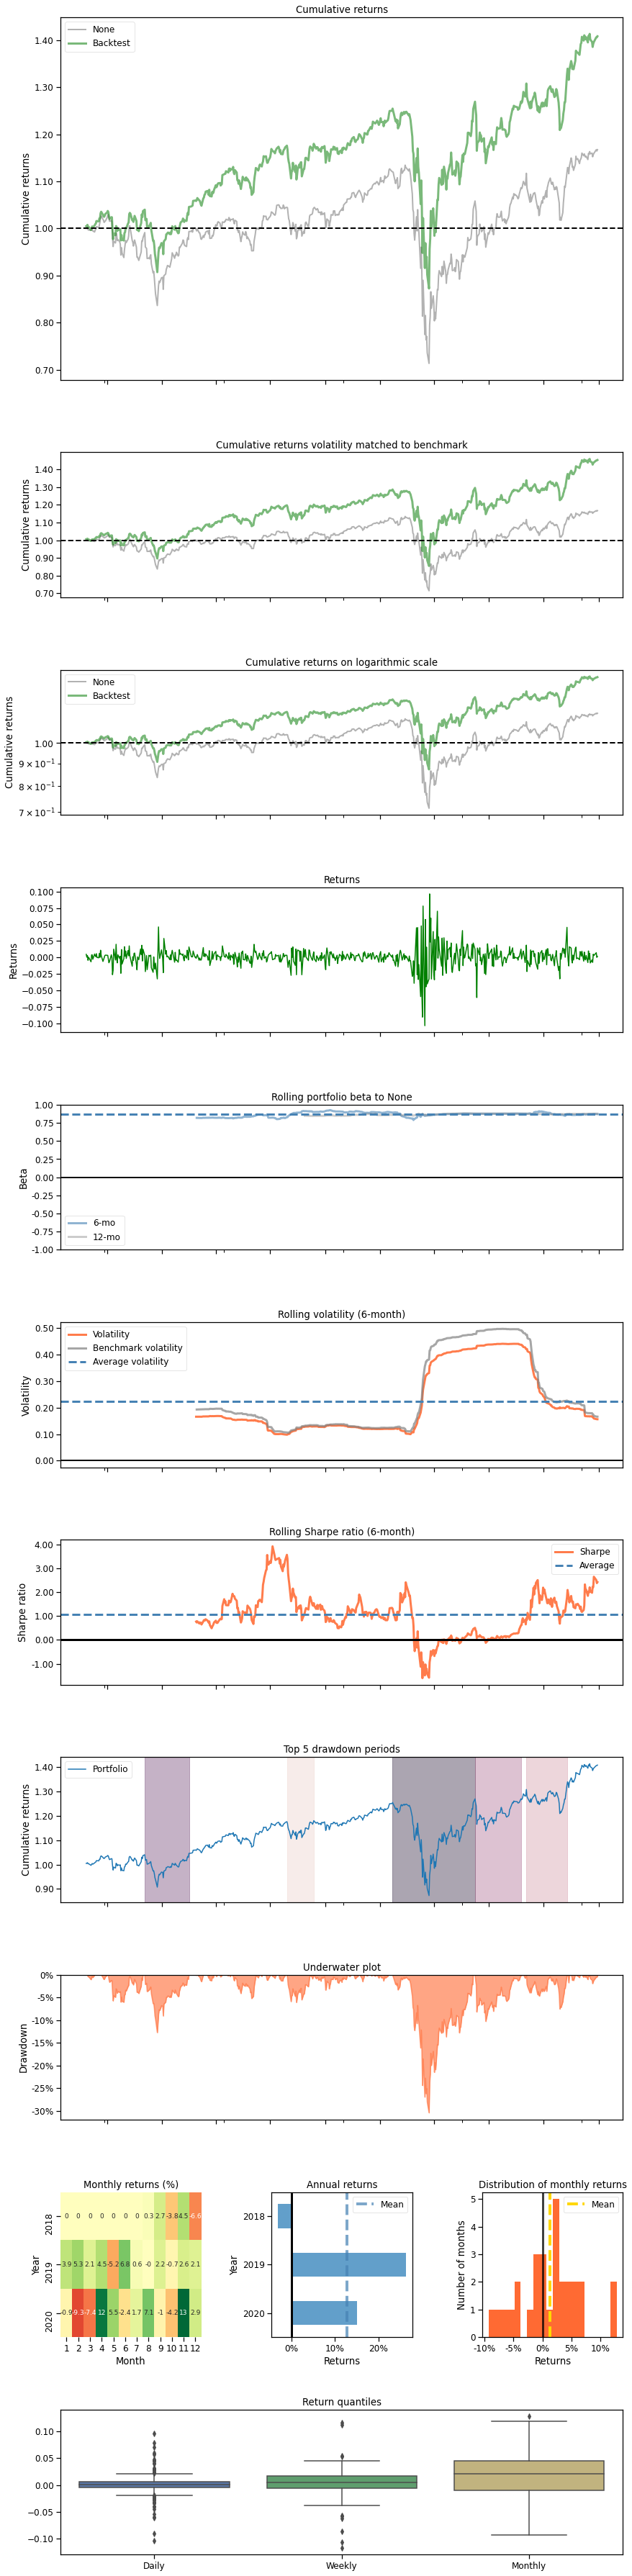

In [115]:
# Get the Benchmarking Plots
import pyfolio
%matplotlib inline
with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = best_port_strat,
                                       benchmark_rets=dow_strat, set_context=False)